# Part 3 : Mitigate Bias, Train another unbiased Model and Put in the Model Registry

<a id='aup-overview'></a>

## [Overview](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 0 : Overview, Architecture and Data Exploration](./0-AutoClaimFraudDetection.ipynb)
* [Notebook 1: Data Prep, Process, Store Features](./1-data-prep-e2e.ipynb)
* [Notebook 2: Train, Check Bias, Tune, Record Lineage, and Register a Model](./2-lineage-train-assess-bias-tune-registry-e2e.ipynb)
* **[Notebook 3: Mitigate Bias, Train New Model, Store in Registry](./3-mitigate-bias-train-model2-registry-e2e.ipynb)**
  * **[Architecture](#train2)**
  * **[Develop a second model](#second-model)**
  * **[Analyze the Second Model for Bias](#analyze-second-model)**
  * **[View Results of Clarify Bias Detection Job](#view-second-clarify-job)**
  * **[Configure and Run Clarify Explainability Job](#explainability)**
  * **[Create Model Package for the Second Trained Model](#model-package)**
* [Notebook 4: Deploy Model, Run Predictions](./4-deploy-run-inference-e2e.ipynb)
* [Notebook 5 : Create and Run an End-to-End Pipeline to Deploy the Model](./5-pipeline-e2e.ipynb)

In this notebook, we will describe how to detect bias using Clarify, Mitigate it with SMOTE, train another model, put it in the Model Registry along with all the Lineage of the Artifacts created along the way: data, code and model metadata.

<a id ='train2'> </a>

## Architecture for this ML Lifecycle Stage : Train, Check Bias, Tune, Record Lineage, Register Model
[overview](#aup-overview)
----

![Data Prep and Store](./images/part3.png)

### Install required and/or update third-party libraries

In [1]:
!python -m pip install -q imbalanced-learn

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


### Import libraries

In [2]:
import json
import time
import boto3
import sagemaker
import numpy as np
import pandas as pd
import awswrangler as wr
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sagemaker.xgboost.estimator import XGBoost

from model_package_src.inference_specification import InferenceSpecification

%matplotlib inline

### Load stored variables
Run the cell below to load any prevously created variables. You should see a print-out of the existing variables. If you don't see anything you may need to create them again or it may be your first time running this notebook.

In [3]:
%store -r
%store

Stored variables and their in-db values:
bucket                              -> 'sagemaker-us-east-1-875692608981'
claims_fg_name                      -> 'fraud-detect-demo-claims'
claims_preprocessed                 ->       policy_id  incident_severity  num_vehicles_i
claims_table                        -> 'fraud-detect-demo-claims-1637200704'
clarify_bias_job_1_name             -> 'Clarify-Bias-2021-11-18-02-16-43-192'
col_order                           -> ['fraud', 'customer_gender_male', 'customer_educat
context_name                        -> 'fraud-detect-1637201755'
customers_fg_name                   -> 'fraud-detect-demo-customers'
customers_preprocessed              ->       policy_id  customer_age  customer_education 
customers_table                     -> 'fraud-detect-demo-customers-1637200706'
database_name                       -> 'sagemaker_featurestore'
dataset_uri                         -> 's3://sagemaker-us-east-1-875692608981/fraud-detec
hyperparameters           

**<font color='red'>Important</font>: You must have run the previous sequential notebooks to retrieve variables using the StoreMagic command.**

### Set region, boto3 and SageMaker SDK variables

In [4]:
# You can change this to a region of your choice
import sagemaker

region = sagemaker.Session().boto_region_name
print("Using AWS Region: {}".format(region))

Using AWS Region: us-east-1


In [5]:
boto3.setup_default_session(region_name=region)
boto_session = boto3.Session(region_name=region)
s3_client = boto3.client("s3", region_name=region)
sagemaker_client = boto_session.client("sagemaker")
sagemaker_session = sagemaker.session.Session(
    boto_session=boto_session, sagemaker_client=sagemaker_client
)
sagemaker_role = sagemaker.get_execution_role()
account_id = boto3.client("sts").get_caller_identity()["Account"]

In [6]:
# variables used for parameterizing the notebook run
model_2_name = f"{prefix}-xgboost-post-smote"

train_data_upsampled_s3_path = f"s3://{bucket}/{prefix}/data/upsampled/train.csv"
bias_report_2_output_path = f"s3://{bucket}/{prefix}/clarify-output/bias-2"
explainability_output_path = f"s3://{bucket}/{prefix}/clarify-output/explainability"

train_instance_count = 1
train_instance_type = "ml.m4.xlarge"

claify_instance_count = 1
clairfy_instance_type = "ml.c5.xlarge"

<a id='second-model'></a>

## Develop a second model

[overview](#aup-overview)
----
In this second model, you will fix the gender imbalance in the dataset using SMOTE and train another model using XGBoost. This model will also be saved to our registry and eventually approved for deployment.

In [7]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

In [8]:
train

,fraud,customer_gender_male,customer_education,incident_type_collision,num_injuries,policy_liability,customer_gender_female,incident_severity,authorities_contacted_fire,collision_type_front,...,police_report_available,incident_dow,num_vehicles_involved,num_insurers_past_5_years,collision_type_side,driver_relationship_self,policy_state_wa,policy_deductable,driver_relationship_other,authorities_contacted_police
0,0,0,3,1,1,0,0,2,0,0,...,1,0,3,4,0,1,0,750,0,1
1,0,0,3,1,0,1,1,1,0,1,...,1,4,2,1,0,1,0,750,0,1
2,0,0,3,1,0,1,1,1,0,1,...,0,4,2,1,0,1,0,750,0,1
3,0,1,0,1,0,1,0,0,0,0,...,1,2,3,1,1,0,1,750,1,1
4,0,1,3,0,0,1,0,1,0,0,...,0,3,1,1,0,0,0,750,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,0,1,3,1,1,0,0,2,0,1,...,0,1,2,1,0,1,0,750,0,1
3996,0,0,1,1,0,0,1,0,0,1,...,0,2,2,4,0,1,0,750,0,0
3997,0,1,3,1,0,0,0,0,0,0,...,1,4,2,3,1,0,0,750,0,1
3998,0,0,1,1,0,2,0,0,0,1,...,1,3,2,1,0,1,0,750,0,1


In [9]:
test

,fraud,customer_gender_male,customer_education,incident_type_collision,num_injuries,policy_liability,customer_gender_female,incident_severity,authorities_contacted_fire,collision_type_front,...,police_report_available,incident_dow,num_vehicles_involved,num_insurers_past_5_years,collision_type_side,driver_relationship_self,policy_state_wa,policy_deductable,driver_relationship_other,authorities_contacted_police
0,0,1,1,0,0,2,0,0,0,0,...,0,6,1,1,0,0,0,750,0,1
1,0,0,3,0,0,1,1,1,0,0,...,0,1,1,4,0,0,0,750,0,1
2,0,0,1,1,2,1,0,1,0,0,...,1,0,2,1,0,0,0,750,0,1
3,0,0,4,1,1,0,1,2,1,1,...,0,3,2,1,0,1,0,750,0,0
4,0,1,1,0,0,0,0,0,0,0,...,1,4,1,1,0,0,0,750,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,2,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,750,0,1
996,0,0,3,1,0,0,0,0,0,0,...,0,2,2,1,1,0,0,750,0,0
997,0,0,3,1,2,1,1,1,0,0,...,0,5,2,3,0,1,0,750,0,1
998,0,0,1,1,1,1,0,2,1,0,...,0,1,2,1,1,1,0,750,0,0


<a id='smote'></a>

### Resolve class imbalance using SMOTE

To handle the imbalance, we can over-sample (i.e. upsample) the minority class using [SMOTE (Synthetic Minority Over-sampling Technique)](https://arxiv.org/pdf/1106.1813.pdf). After installing the imbalanced-learn module, if you receive an ImportError when importing SMOTE, then try restarting the kernel. 

![train-assess-tune-register](./images/smote.png)

#### Gender balance before SMOTE

In [10]:
gender = train["customer_gender_female"]
gender.value_counts()

0    2228
1    1772
Name: customer_gender_female, dtype: int64

#### Gender balance after SMOTE

In [11]:
sm = SMOTE(random_state=42)
train_data_upsampled, gender_res = sm.fit_resample(train, gender)
train_data_upsampled["customer_gender_female"].value_counts()

0    2228
1    2228
Name: customer_gender_female, dtype: int64

### Train new model


![train-assess-tune-register](./images/trainingjob2.png)

In [12]:
train_data_upsampled.to_csv("data/upsampled.csv", index=False)
s3_client.upload_file(
    Filename="data/upsampled.csv",
    Bucket=bucket,
    Key=f"{prefix}/data/upsampled/train.csv",
)

In [13]:
xgb_estimator = XGBoost(
    entry_point="code/xgboost_starter_script.py",
    hyperparameters=hyperparameters,
    role=sagemaker_role,
    instance_count=train_instance_count,
    instance_type=train_instance_type,
    framework_version="1.0-1",
)

In [14]:
if 'training_job_2_name' not in locals():
    
    xgb_estimator.fit(inputs = {'train': train_data_upsampled_s3_path})
    training_job_2_name = xgb_estimator.latest_training_job.job_name
    %store training_job_2_name
    
else:
    
    print(f'Using previous training job: {training_job_2_name}')

2021-11-18 02:31:29 Starting - Starting the training job...
2021-11-18 02:31:53 Starting - Launching requested ML instancesProfilerReport-1637202688: InProgress
......
2021-11-18 02:32:53 Starting - Preparing the instances for training............
2021-11-18 02:34:54 Downloading - Downloading input data...
2021-11-18 02:35:28 Training - Training image download completed. Training in progress...INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Invoking user training script.
INFO:sagemaker-containers:Module xgboost_starter_script does not provide a setup.py. 
Generating setup.py
INFO:sagemaker-containers:Generating setup.cfg
INFO:sagemaker-containers:Generating MANIFEST.in
INFO:sagemaker-containers:Installing module with the following command:
/miniconda3/bin/python3 -m pip install . 
Processing /opt/ml/code
  Created wheel for xgboost-starter

<a id='model-lineage'></a>

## Model lineage with artifacts and associations

[Overview](#aud-overview)
----
Amazon SageMaker ML Lineage Tracking creates and stores information about the steps of a machine learning (ML) workflow from data preparation to model deployment. With the tracking information you can reproduce the workflow steps, track model and dataset lineage, and establish model governance and audit standards. With SageMaker Lineage Tracking data scientists and model builders can do the following:
* Keep a running history of model discovery experiments.
* Establish model governance by tracking model lineage artifacts for auditing and compliance verification.
* Clone and rerun workflows to experiment with what-if scenarios while developing models.
* Share a workflow that colleagues can reproduce and enhance (for example, while collaborating on solving a business problem).
* Clone and rerun workflows with additional debugging or logging routines, or new input variations for troubleshooting issues in production models.




![train-assess-tune-register](./images/lineage2.png)

In [15]:
from datetime import datetime
from sagemaker.lineage.context import Context
from sagemaker.lineage.action import Action
from sagemaker.lineage.association import Association
from sagemaker.lineage.artifact import Artifact

unique_id = str(int(datetime.now().replace(microsecond=0).timestamp()))

print(f"Unique id is {unique_id}")

Unique id is 1637202972


### Register artifacts

In [16]:
training_job_2_info = sagemaker_client.describe_training_job(
    TrainingJobName=training_job_2_name
)
training_job_2_info

{'TrainingJobName': 'sagemaker-xgboost-2021-11-18-02-31-28-835',
 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:875692608981:training-job/sagemaker-xgboost-2021-11-18-02-31-28-835',
 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/output/model.tar.gz'},
 'TrainingJobStatus': 'Completed',
 'SecondaryStatus': 'Completed',
 'HyperParameters': {'eta': '"0.2"',
  'max_depth': '"3"',
  'num_round': '"100"',
  'objective': '"binary:logistic"',
  'sagemaker_container_log_level': '20',
  'sagemaker_job_name': '"sagemaker-xgboost-2021-11-18-02-31-28-835"',
  'sagemaker_program': '"xgboost_starter_script.py"',
  'sagemaker_region': '"us-east-1"',
  'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/source/sourcedir.tar.gz"'},
 'AlgorithmSpecification': {'TrainingImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3',
  'TrainingInput

#### Code artifact

In [17]:
# return any existing artifact which match the our training job's code arn
code_s3_uri = training_job_2_info["HyperParameters"]["sagemaker_submit_directory"]
print(f"Code path: {code_s3_uri }")
list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=code_s3_uri, sagemaker_session=sagemaker_session
    )
)

# use existing arifact if it's already been created, otherwise create a new artifact
if list_response:
    code_artifact = list_response[0]
    print(f"Using existing artifact: {code_artifact.artifact_arn}")
else:
    code_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingScript",
        source_uri=code_s3_uri,
        artifact_type="Code",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {code_artifact.artifact_arn}: SUCCESSFUL")

Code path: "s3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/source/sourcedir.tar.gz"
Create artifact arn:aws:sagemaker:us-east-1:875692608981:artifact/0fbe9bd9de57d2cb2d23aa0ca5aed1b8: SUCCESSFUL


#### Training data artifact

In [18]:
training_data_s3_uri = training_job_2_info["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3Uri"
]
print(f"Training Data path: {training_data_s3_uri}")

list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=training_data_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    training_data_artifact = list_response[0]
    print(f"Using existing artifact: {training_data_artifact.artifact_arn}")
else:
    training_data_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainingData",
        source_uri=training_data_s3_uri,
        artifact_type="Dataset",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {training_data_artifact.artifact_arn}: SUCCESSFUL")

Training Data path: s3://sagemaker-us-east-1-875692608981/fraud-detect-demo/data/upsampled/train.csv
Using existing artifact: arn:aws:sagemaker:us-east-1:875692608981:artifact/80c3e819464730066ac9c0ca38aaf27f


#### Model artifact

In [19]:
trained_model_s3_uri = training_job_2_info["ModelArtifacts"]["S3ModelArtifacts"]
print(f"Training Model path: {trained_model_s3_uri}")
list_response = list(
    sagemaker.lineage.artifact.Artifact.list(
        source_uri=trained_model_s3_uri, sagemaker_session=sagemaker_session
    )
)

if list_response:
    model_artifact = list_response[0]
    print(f"Using existing artifact: {model_artifact.artifact_arn}")
else:
    model_artifact = sagemaker.lineage.artifact.Artifact.create(
        artifact_name="TrainedModel",
        source_uri=trained_model_s3_uri,
        artifact_type="Model",
        sagemaker_session=sagemaker_session,
    )
    print(f"Create artifact {model_artifact.artifact_arn}: SUCCESSFUL")

Training Model path: s3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/output/model.tar.gz
Using existing artifact: arn:aws:sagemaker:us-east-1:875692608981:artifact/cbd1fd8e87bb6f5dc2e766b2889b30dc


### Set artifact associations

In [20]:
trial_component = sagemaker_client.describe_trial_component(
    TrialComponentName=training_job_2_name + "-aws-training-job"
)
trial_component_arn = trial_component["TrialComponentArn"]
trial_component_arn

'arn:aws:sagemaker:us-east-1:875692608981:experiment-trial-component/sagemaker-xgboost-2021-11-18-02-31-28-835-aws-training-job'

#### Input artifacts

In [21]:
input_artifacts = [code_artifact, training_data_artifact]

for a in input_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="ContributedTo",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-1:875692608981:experiment-trial-component/sagemaker-xgboost-2021-11-18-02-31-28-835-aws-training-job and arn:aws:sagemaker:us-east-1:875692608981:artifact/0fbe9bd9de57d2cb2d23aa0ca5aed1b8: SUCCEESFUL

Association already exists between arn:aws:sagemaker:us-east-1:875692608981:experiment-trial-component/sagemaker-xgboost-2021-11-18-02-31-28-835-aws-training-job and arn:aws:sagemaker:us-east-1:875692608981:artifact/80c3e819464730066ac9c0ca38aaf27f.



#### Output artifacts

In [22]:
output_artifacts = [model_artifact]

for a in output_artifacts:
    try:
        sagemaker.lineage.association.Association.create(
            source_arn=a.artifact_arn,
            destination_arn=trial_component_arn,
            association_type="Produced",
            sagemaker_session=sagemaker_session,
        )
        print(f"Associate {trial_component_arn} and {a.artifact_arn}: SUCCEESFUL\n")
    except:
        print(f"Association already exists between {trial_component_arn} and {a.artifact_arn}.\n")

Associate arn:aws:sagemaker:us-east-1:875692608981:experiment-trial-component/sagemaker-xgboost-2021-11-18-02-31-28-835-aws-training-job and arn:aws:sagemaker:us-east-1:875692608981:artifact/cbd1fd8e87bb6f5dc2e766b2889b30dc: SUCCEESFUL



In [23]:
# list all the contexts
contexts = Context.list(sort_by="CreationTime", sort_order="Descending")
print(context_name)
for ctx in contexts:
    if ctx.context_name == context_name:
        context_arn = ctx.context_arn
        print(ctx.context_arn)

fraud-detect-1637201755
arn:aws:sagemaker:us-east-1:875692608981:context/fraud-detect-1637201755


In [24]:
# create an example action and associate it with the context

model_build_action = Action.create(
    action_name=f"model-train-{unique_id}",
    action_type="ModelBuild",
    source_uri=trial_component_arn,
    properties={"Example": "Metadata"},
)

In [25]:
# Association Type can be Produced|DerivedFrom|AssociatedWith|ContributedTo
context_action_association = Association.create(
    source_arn=context_arn,
    destination_arn=trial_component_arn,
    association_type="AssociatedWith",
)

## Tracking Lineage

In [26]:
#Tracking Dataset Source Lineage
train_data_location_artifact_arn = sagemaker_client.list_associations(
    DestinationArn=trial_component_arn, SourceType='DataSet')['AssociationSummaries'][0]['SourceArn']
# print(train_data_location_artifact_arn)

train_data_location = sagemaker_client.describe_artifact(ArtifactArn=train_data_location_artifact_arn)['Source']['SourceUri']
print(train_data_location)

s3://sagemaker-us-east-1-875692608981/fraud-detect-demo/data/upsampled/train.csv


In [27]:
#Tracking Dataset Model Lineage
train_data_location_artifact_arn = sagemaker_client.list_associations(
    DestinationArn=trial_component_arn, SourceType='Model')['AssociationSummaries'][0]['SourceArn']
# print(train_data_location_artifact_arn)

train_data_location = sagemaker_client.describe_artifact(ArtifactArn=train_data_location_artifact_arn)['Source']['SourceUri']
print(train_data_location)

s3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/output/model.tar.gz


In [28]:
train_data_location_artifact_arn = sagemaker_client.list_associations(
    DestinationArn=trial_component_arn, SourceType='Model')
print(train_data_location_artifact_arn)

{'AssociationSummaries': [{'SourceArn': 'arn:aws:sagemaker:us-east-1:875692608981:artifact/cbd1fd8e87bb6f5dc2e766b2889b30dc', 'DestinationArn': 'arn:aws:sagemaker:us-east-1:875692608981:experiment-trial-component/sagemaker-xgboost-2021-11-18-02-31-28-835-aws-training-job', 'SourceType': 'Model', 'DestinationType': 'SageMakerTrainingJob', 'AssociationType': 'Produced', 'DestinationName': 'sagemaker-xgboost-2021-11-18-02-31-28-835-aws-training-job', 'CreationTime': datetime.datetime(2021, 11, 18, 2, 36, 29, 755000, tzinfo=tzlocal()), 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:875692608981:user-profile/d-hztgxavtcaey/yikyakyuk-aec', 'UserProfileName': 'yikyakyuk-aec', 'DomainId': 'd-hztgxavtcaey'}}], 'ResponseMetadata': {'RequestId': 'a7eccee8-fe5b-4872-925a-539f9fdb64d3', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a7eccee8-fe5b-4872-925a-539f9fdb64d3', 'content-type': 'application/x-amz-json-1.1', 'content-length': '651', 'date': 'Thu, 18 Nov 2021 02:36

In [29]:
#Tracking Dataset Code Lineage
train_data_location_artifact_arn = sagemaker_client.list_associations(
    DestinationArn=trial_component_arn, SourceType='Code')['AssociationSummaries'][0]['SourceArn']
# print(train_data_location_artifact_arn)

train_data_location = sagemaker_client.describe_artifact(ArtifactArn=train_data_location_artifact_arn)['Source']['SourceUri']
print(train_data_location)

"s3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/source/sourcedir.tar.gz"


<pre>

</pre>

<a id ='analyze-second-model'></a>

## Analyze the second model for bias and explainability

[overview](#aup-overview)
----
Amazon SageMaker Clarify provides tools to help explain how machine learning (ML) models make predictions. These tools can help ML modelers and developers and other internal stakeholders understand model characteristics as a whole prior to deployment and to debug predictions provided by the model after it's deployed. Transparency about how ML models arrive at their predictions is also critical to consumers and regulators who need to trust the model predictions if they are going to accept the decisions based on them. SageMaker Clarify uses a model-agnostic feature attribution approach, which you can used to understand why a model made a prediction after training and to provide per-instance explanation during inference. The implementation includes a scalable and efficient implementation of SHAP ([see paper](https://papers.nips.cc/paper/2017/file/8a20a8621978632d76c43dfd28b67767-Paper.pdf)), based on the concept of a Shapley value from the field of cooperative game theory that assigns each feature an importance value for a particular prediction. 


![train-assess-tune-register](./images/clarify.png)

### Create model from estimator

In [30]:
model_matches = sagemaker_client.list_models(NameContains=model_2_name)['Models']

if not model_matches:
    
    model_2 = sagemaker_session.create_model_from_job(
        name=model_2_name,
        training_job_name=training_job_2_info['TrainingJobName'],
        role=sagemaker_role,
        image_uri=training_job_2_info['AlgorithmSpecification']['TrainingImage'])
    %store model_2_name
    
else:
    
    print(f"Model {model_2_name} already exists.")

Stored 'model_2_name' (str)


<a id='bias-v1'></a>

### Check for data set bias and model bias

With SageMaker, we can check for pre-training and post-training bias. Pre-training metrics show pre-existing bias in that data, while post-training metrics show bias in the predictions from the model. Using the SageMaker SDK, we can specify which groups we want to check bias across and which metrics we'd like to show. 

To run the full Clarify job, you must un-comment the code in the cell below. Running the job will take ~15 minutes. If you wish to save time, you can view the results in the next cell after which loads a pre-generated output if no bias job was run.

In [31]:
clarify_processor = sagemaker.clarify.SageMakerClarifyProcessor(
    role=sagemaker_role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    sagemaker_session=sagemaker_session,
)

bias_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=bias_report_2_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

predictions_config = sagemaker.clarify.ModelPredictedLabelConfig(probability_threshold=0.5)

bias_config = sagemaker.clarify.BiasConfig(
    label_values_or_threshold=[0],
    facet_name="customer_gender_female",
    facet_values_or_threshold=[1],
)

# # un-comment the code below to run the whole job

if 'clarify_bias_job_2_name' not in locals():

    clarify_processor.run_bias(
        data_config=bias_data_config,
        bias_config=bias_config,
        model_config=model_config,
        model_predicted_label_config=predictions_config,
        pre_training_methods='all',
        post_training_methods='all')

    clarify_bias_job_2_name = clarify_processor.latest_job.name
    %store clarify_bias_job_2_name

else:
    print(f'Clarify job {clarify_bias_job_2_name} has already run successfully.')


Job Name:  Clarify-Bias-2021-11-18-02-37-10-321
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/data/upsampled/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/clarify-output/bias-2/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/clarify-output/bias-2', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
............................

<a id ='view-second-clarify-job'></a>

## View results of Clarify job
[overview](#aup-overview)
----

Running Clarify on your dataset or model can take ~15 minutes. If you don't have time to run the job, you can view the pre-generated results included with this demo. Otherwise, you can run the job by un-commenting the code in the cell above.

In [32]:
if "clarify_bias_job_2_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/bias-2/analysis.json",
        Filename="clarify_output/bias_2/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_bias_job_2_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/bias_1/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

with open("clarify_output/bias_2/analysis.json", "r") as f:
    bias_analysis = json.load(f)

results = bias_analysis["pre_training_bias_metrics"]["facets"]["customer_gender_female"][0][
    "metrics"
][1]
print(json.dumps(results, indent=4))

Downloaded analysis from previous Clarify job: Clarify-Bias-2021-11-18-02-37-10-321

{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.114
}
{
    "name": "CI",
    "description": "Class Imbalance (CI)",
    "value": 0.0
}


<a id ='explainability' ></a>

## Configure and run explainability job
[overview](#aup-overview)
----
To run the full Clarify job, you must un-comment the code in the cell below. Running the job will take ~15 minutes. If you wish to save time, you can view the results in the next cell after which loads a pre-generated output if no explainability job was run.


![train-assess-tune-register](./images/explain.png)

In [33]:
model_config = sagemaker.clarify.ModelConfig(
    model_name=model_2_name,
    instance_type=train_instance_type,
    instance_count=1,
    accept_type="text/csv",
)

shap_config = sagemaker.clarify.SHAPConfig(
    baseline=[train.median().values[1:].tolist()], num_samples=100, agg_method="mean_abs"
)

explainability_data_config = sagemaker.clarify.DataConfig(
    s3_data_input_path=train_data_upsampled_s3_path,
    s3_output_path=explainability_output_path,
    label="fraud",
    headers=train.columns.to_list(),
    dataset_type="text/csv",
)

# un-comment the code below to run the whole job

if 'clarify_expl_job_name' not in locals():

    clarify_processor.run_explainability(
        data_config=explainability_data_config,
        model_config=model_config,
        explainability_config=shap_config)

    clarify_expl_job_name = clarify_processor.latest_job.name
    %store clarify_expl_job_name

else:
    print(f'Clarify job {clarify_expl_job_name} has already run successfully.')


Job Name:  Clarify-Explainability-2021-11-18-02-49-06-695
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/data/upsampled/train.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/clarify-output/explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/clarify-output/explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
..

### View Clarify explainability results (shortcut)
Running Clarify on your dataset or model can take ~15 minutes. If you don't have time to run the job, you can view the pre-generated results included with this demo. Otherwise, you can run the job by un-commenting the code in the cell above.

Downloaded analysis from previous Clarify job: Clarify-Explainability-2021-11-18-02-49-06-695



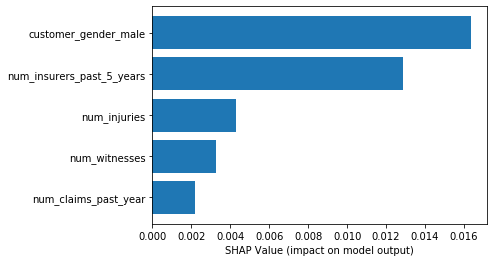

In [34]:
if "clarify_expl_job_name" in locals():
    s3_client.download_file(
        Bucket=bucket,
        Key=f"{prefix}/clarify-output/explainability/analysis.json",
        Filename="clarify_output/explainability/analysis.json",
    )
    print(f"Downloaded analysis from previous Clarify job: {clarify_expl_job_name}\n")
else:
    print(f"Loading pre-generated analysis file...\n")

with open("clarify_output/explainability/analysis.json", "r") as f:
    analysis_result = json.load(f)

shap_values = pd.DataFrame(analysis_result["explanations"]["kernel_shap"]["label0"])
importances = shap_values["global_shap_values"].sort_values(ascending=False)
fig, ax = plt.subplots()
n = 5
y_pos = np.arange(n)
importance_scores = importances.values[:n]
y_label = importances.index[:n]
ax.barh(y_pos, importance_scores, align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(y_label)
ax.invert_yaxis()
ax.set_xlabel("SHAP Value (impact on model output)");

To see the autogenerated SageMaker Clarify report, run the following code and use the output link to open the report.

In [35]:
from IPython.display import FileLink, FileLinks

display(
    "Click link below to view the SageMaker Clarify report", FileLink("clarify_output/report.pdf")
)

'Click link below to view the SageMaker Clarify report'

/root/mlt/clarify_output/report.pdf

### What is SHAP?
SHAP is the method used for calculating explanations in this solution.
Unlike other feature attribution methods, such as single feature
permutation, SHAP tries to disentangle the effect of a single feature by
looking at all possible combinations of features.

[SHAP](https://github.com/slundberg/shap) (Lundberg et al. 2017) stands
for SHapley Additive exPlanations. 'Shapley' relates to a game theoretic
concept called [Shapley
values](https://en.wikipedia.org/wiki/Shapley_value) that is used to
create the explanations. A Shapley value describes the marginal
contribution of each 'player' when considering all possible 'coalitions'.
Using this in a machine learning context, a Shapley value  describes the
marginal contribution of each feature when considering all possible sets
of features. 'Additive' relates to the fact that these Shapley values can
be summed together to give the final model prediction.

As an example, we might start off with a baseline credit default risk of
10%. Given a set of features, we can calculate the Shapley value for each
feature. Summing together all the Shapley values, we might obtain a
cumulative value of +30%. Given the same set of features, we therefore
expect our model to return a credit default risk of 40% (i.e. 10% + 30%).

<a id='model-package' ></a>

## Create Model Package for the Second Trained Model
[overview](#aup-overview)
----


![train-assess-tune-register](./images/modelregistry.png)

#### Create and upload second model metrics report

In [40]:
model_metrics_report = {"binary_classification_metrics": {}}
for metric in training_job_2_info["FinalMetricDataList"]:
    stat = {metric["MetricName"]: {"value": metric["Value"], "standard_deviation": "NaN"}}
    model_metrics_report["binary_classification_metrics"].update(stat)
    print(metric)

with open("training_metrics.json", "w") as f:
    json.dump(model_metrics_report, f)

metrics_s3_key = (
    f"{prefix}/training_jobs/{training_job_2_info['TrainingJobName']}/training_metrics.json"
)
s3_client.upload_file(Filename="training_metrics.json", Bucket=bucket, Key=metrics_s3_key)

{'MetricName': 'validation:auc', 'Value': 0.8241829872131348, 'Timestamp': datetime.datetime(2021, 11, 18, 2, 35, 36, tzinfo=tzlocal())}
{'MetricName': 'train:auc', 'Value': 0.9009028077125549, 'Timestamp': datetime.datetime(2021, 11, 18, 2, 35, 36, tzinfo=tzlocal())}


#### Define inference specification

In [41]:
mp_inference_spec = InferenceSpecification().get_inference_specification_dict(
    ecr_image=training_job_2_info["AlgorithmSpecification"]["TrainingImage"],
    supports_gpu=False,
    supported_content_types=["text/csv"],
    supported_mime_types=["text/csv"],
)

mp_inference_spec["InferenceSpecification"]["Containers"][0]["ModelDataUrl"] = training_job_2_info[
    "ModelArtifacts"
]["S3ModelArtifacts"]
print(mp_inference_spec)

{'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.0-1-cpu-py3', 'ModelDataUrl': 's3://sagemaker-us-east-1-875692608981/sagemaker-xgboost-2021-11-18-02-31-28-835/output/model.tar.gz'}], 'SupportedTransformInstanceTypes': ['ml.m4.xlarge', 'ml.m4.2xlarge', 'ml.m4.4xlarge', 'ml.m4.10xlarge', 'ml.m4.16xlarge', 'ml.m5.large', 'ml.m5.xlarge', 'ml.m5.2xlarge', 'ml.m5.4xlarge', 'ml.m5.12xlarge', 'ml.m5.24xlarge', 'ml.c4.xlarge', 'ml.c4.2xlarge', 'ml.c4.4xlarge', 'ml.c4.8xlarge', 'ml.c5.xlarge', 'ml.c5.2xlarge', 'ml.c5.4xlarge', 'ml.c5.9xlarge', 'ml.c5.18xlarge'], 'SupportedRealtimeInferenceInstanceTypes': ['ml.m4.xlarge', 'ml.m4.2xlarge', 'ml.m4.4xlarge', 'ml.m4.10xlarge', 'ml.m4.16xlarge', 'ml.m5.large', 'ml.m5.xlarge', 'ml.m5.2xlarge', 'ml.m5.4xlarge', 'ml.m5.12xlarge', 'ml.m5.24xlarge', 'ml.c4.xlarge', 'ml.c4.2xlarge', 'ml.c4.4xlarge', 'ml.c4.8xlarge', 'ml.c5.xlarge', 'ml.c5.2xlarge', 'ml.c5.4xlarge', 'ml.c5.9xlarge', 'ml.c

#### Define model metrics

In [42]:
model_metrics = {
    "ModelQuality": {
        "Statistics": {
            "ContentType": "application/json",
            "S3Uri": f"s3://{bucket}/{metrics_s3_key}",
        }
    },
    "Bias": {
        "Report": {
            "ContentType": "application/json",
            "S3Uri": f"{explainability_output_path}/analysis.json",
        }
    },
}
print(model_metrics)

{'ModelQuality': {'Statistics': {'ContentType': 'application/json', 'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/training_jobs/sagemaker-xgboost-2021-11-18-02-31-28-835/training_metrics.json'}}, 'Bias': {'Report': {'ContentType': 'application/json', 'S3Uri': 's3://sagemaker-us-east-1-875692608981/fraud-detect-demo/clarify-output/explainability/analysis.json'}}}


#### Register second model package to Model Package Group

In [43]:
mp_input_dict = {
    "ModelPackageGroupName": mpg_name,
    "ModelPackageDescription": "XGBoost classifier to detect insurance fraud with SMOTE.",
    "ModelApprovalStatus": "PendingManualApproval",
    "ModelMetrics": model_metrics,
}

mp_input_dict.update(mp_inference_spec)
mp2_response = sagemaker_client.create_model_package(**mp_input_dict)
mp2_arn = mp2_response["ModelPackageArn"]
%store mp2_arn
print(mp2_response)

Stored 'mp2_arn' (str)
{'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:875692608981:model-package/fraud-detect-demo/3', 'ResponseMetadata': {'RequestId': '5f9a6f44-8596-4776-81c6-7d601fc77606', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '5f9a6f44-8596-4776-81c6-7d601fc77606', 'content-type': 'application/x-amz-json-1.1', 'content-length': '96', 'date': 'Thu, 18 Nov 2021 03:07:04 GMT'}, 'RetryAttempts': 0}}


#### Check status of model package creation

In [44]:
mp_info = sagemaker_client.describe_model_package(
    ModelPackageName=mp2_response["ModelPackageArn"]
)
mp_status = mp_info["ModelPackageStatus"]

while mp_status not in ["Completed", "Failed"]:
    time.sleep(5)
    mp_info = sagemaker_boto_client.describe_model_package(
        ModelPackageName=mp2_response["ModelPackageArn"]
    )
    mp_status = mp_info["ModelPackageStatus"]
    print(f"model package status: {mp_status}")
print(f"model package status: {mp_status}")

model package status: Completed


### View both models in the registry

In [45]:
sagemaker_client.list_model_packages(ModelPackageGroupName=mpg_name)["ModelPackageSummaryList"]

[{'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 3,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:875692608981:model-package/fraud-detect-demo/3',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2021, 11, 18, 3, 7, 4, 923000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 2,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:875692608981:model-package/fraud-detect-demo/2',
  'ModelPackageDescription': 'XGBoost classifier to detect insurance fraud with SMOTE.',
  'CreationTime': datetime.datetime(2021, 11, 18, 3, 5, 36, 244000, tzinfo=tzlocal()),
  'ModelPackageStatus': 'Completed',
  'ModelApprovalStatus': 'PendingManualApproval'},
 {'ModelPackageGroupName': 'fraud-detect-demo',
  'ModelPackageVersion': 1,
  'ModelPackageArn': 'arn:aws:sagemaker:us-east

----

### Next Notebook: [Deploy Model, Run Predictions](./06-Deploy-Run-Inference.ipynb)